In [37]:
import datasets 
import numpy as np
import os
import time
import torch
import tensorflow as tf
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
# import torchvision
import torchtext
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import numpy as np
from langdetect import detect_langs
from torch.nn.utils.rnn import pad_sequence
from pandarallel import pandarallel 
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.metrics import hamming_loss

if torch.cuda.is_available():  
  use_cuda = True
else:  
  use_cuda = False



In [38]:
# loading GLOVE embeddings
GLOVE = torchtext.vocab.GloVe(name="6B", dim=50, max_vectors=10000)  # use 10k most common words

In [39]:
# loading dataset
dataset = datasets.load_dataset('ucberkeley-dlab/measuring-hate-speech', 'binary')   
df = dataset['train'].to_pandas()
df.describe()

Using custom data configuration ucberkeley-dlab--measuring-hate-speech-c32713cabe528196
Found cached dataset parquet (/Users/angelinazhai/.cache/huggingface/datasets/ucberkeley-dlab___parquet/ucberkeley-dlab--measuring-hate-speech-c32713cabe528196/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

,comment_id,annotator_id,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,...,hatespeech,hate_speech_score,infitms,outfitms,annotator_severity,std_err,annotator_infitms,annotator_outfitms,hypothesis,annotator_age
count,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.00000,135556.000000,135556.000000,135556.000000,135556.000000,...,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135451.000000
mean,23530.416138,5567.097812,1.281352,2.954307,2.828875,2.56331,2.278638,2.698575,1.846211,1.052045,...,0.744733,-0.567428,1.034322,1.001052,-0.018817,0.300588,1.007158,1.011841,0.014589,37.910772
std,12387.194125,3230.508937,1.023542,1.231552,1.309548,1.38983,1.370876,0.898500,1.402372,1.345706,...,0.932260,2.380003,0.496867,0.791943,0.487261,0.236380,0.269876,0.675863,0.613006,11.641276
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-8.340000,0.100000,0.070000,-1.820000,0.020000,0.390000,0.280000,-1.578693,18.000000
25%,18148.000000,2719.000000,0.000000,2.000000,2.000000,2.00000,1.000000,2.000000,1.000000,0.000000,...,0.000000,-2.330000,0.710000,0.560000,-0.380000,0.030000,0.810000,0.670000,-0.341008,29.000000
50%,20052.000000,5602.500000,1.000000,3.000000,3.000000,3.00000,3.000000,3.000000,2.000000,0.000000,...,0.000000,-0.340000,0.960000,0.830000,-0.020000,0.340000,0.970000,0.850000,0.110405,35.000000
75%,32038.250000,8363.000000,2.000000,4.000000,4.000000,4.00000,3.000000,3.000000,3.000000,2.000000,...,2.000000,1.410000,1.300000,1.220000,0.350000,0.420000,1.170000,1.130000,0.449555,45.000000
max,50070.000000,11142.000000,3.000000,4.000000,4.000000,4.00000,4.000000,4.000000,4.000000,4.000000,...,2.000000,6.300000,5.900000,9.000000,1.360000,1.900000,2.010000,9.000000,0.987511,81.000000


In [40]:
#load numpy array from file
tmp_np_arr = np.load('hate_speech.npy', allow_pickle=True)

#convert to pandas dataframe
df.drop(df.iloc[:, 15:131], inplace=True, axis=1)
df_tmp = df.drop(["annotator_id"], axis=1)
df_norm = pd.DataFrame(tmp_np_arr, columns=df_tmp.columns)

In [41]:
df_spliced = df_norm.drop('comment_id', axis=1)
df_spliced = df_spliced.drop('platform', axis=1)
df_spliced = df_spliced.drop('sentiment', axis=1)
df_spliced = df_spliced.drop('hatespeech', axis=1)
df_spliced = df_spliced.drop('hate_speech_score', axis=1)

In [42]:
tweets = df_spliced.iloc[:,-1:]
labels = df_spliced.iloc[:,:-1]
labels = labels.to_numpy()
label_names = list(df_spliced.iloc[:,:-1].columns)
train_size = int(0.7*len(df_spliced))
val_size = int((len(df_spliced) - train_size)/2)
test_size = len(df_spliced) - train_size - val_size

In [43]:
def split_tweet(tweet):
    # separate punctuations
    tweet = tweet.replace(".", " . ") \
                 .replace(",", " , ") \
                 .replace(";", " ; ") \
                 .replace("?", " ? ")
    return tweet.lower().split()

In [44]:
def get_tweet_words(glove_vector):
    train, valid, test = [], [], []
    for index, row in df_spliced.iterrows():
        try:
            tweet = row[-1]
            idxs = [glove_vector.stoi[w]        # lookup the index of word
                    for w in split_tweet(tweet)
                    if w in glove_vector.stoi] # keep words that has an embedding
            if not idxs: # ignore tweets without any word with an embedding
                continue
            idxs = torch.tensor(idxs) # convert list to pytorch tensor
            label = np.array(row[:-1].values).astype(np.float32) 
            label = torch.tensor(label) #storing label information to tensor
            #adding tweet to corresponding train/val/test set
            if index < train_size:
                train.append((idxs, label))
            elif index < train_size+val_size:
                valid.append((idxs, label))
            else:
                test.append((idxs, label))
        except:
            print("Error at index: ", index)
            continue
    return train, valid, test

train, valid, test = get_tweet_words(GLOVE)

In [45]:
from torch import nn
from torch.nn.utils.rnn import pad_sequence

def pad_collate(batch):
  (xx, yy) = zip(*batch)
  x_lens = [len(x) for x in xx]
  y_lens = [len(y) for y in yy]

  xx_pad = pad_sequence(xx, batch_first=True, padding_value=0)
  yy_pad = pad_sequence(yy, batch_first=True, padding_value=0)

  return xx_pad, yy_pad
  
train_loader = torch.utils.data.DataLoader(train[:10], batch_size=10, shuffle=True, collate_fn=pad_collate)
valid_loader = torch.utils.data.DataLoader(valid[:10], batch_size=10, shuffle=True, collate_fn=pad_collate)
test_loader = torch.utils.data.DataLoader(test, batch_size=10, shuffle=True, collate_fn=pad_collate)

In [46]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim*2, 512)
        # self.fc6 = nn.Linear(1024, 512)
        self.fc7 = nn.Linear(512, 256)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, output_dim)
        self.relu = nn.ReLU()
        # self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        # embedded = self.dropout(self.embedding(text))
        embedded = self.embedding(text)
        output, (hidden, cell) = self.rnn(embedded)
        # hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        hidden = self.relu(self.fc(hidden))
        # hidden = self.relu(self.fc6(hidden))
        hidden = self.relu(self.fc7(hidden))
        hidden = self.relu(self.fc1(hidden))
        hidden = self.relu(self.fc2(hidden))
        hidden = self.relu(self.fc3(hidden))
        hidden = self.relu(self.fc4(hidden))
        return self.fc5(hidden.squeeze(0))

In [52]:
# #training loop
# def train(model, iterator, optimizer, criterion):
#     epoch_loss = 0
#     epoch_acc = 0
#     model.train()
#     for text, label in 
#         # epoch_acc += acc.item()
#     return epoch_loss / len(iterator), 0

def get_accuracy(model, training_mode, train_loader, valid_loader, size):
    if training_mode == True:
        loader = train_loader
    else:
        loader = valid_loader
    

    hamming = []
    for text, label in loader:
        predictions = model(text)
        # f1_scores.append(f1_score(label, predictions, average='macro'))
        #detatching the tensor from the graph
        predictions = predictions.detach().numpy()
        label = label.squeeze().detach().numpy()

        # predictions[predictions >= 0.5] = 1
        # predictions[predictions < 0.5] = 0

        predictions = np.where(predictions >= 0.6, 1, 0)
        label = np.where(label >= 0.6, 1, 0)

        # print(predictions.shape)
        # print(label.shape)
        #compute hamming loss
        # hamming.append(hamming_loss(label, predictions))
        hamming.append(f1_score(label, predictions, average='macro'))

    return np.mean(hamming)
    


# def train_net(net, batch_size, train_loader, valid_loader, optimizer, criterion, epochs=10):
def train_net(net, batch_size, learning_rate, epochs=10):

    train_loader = torch.utils.data.DataLoader(train[:1000], batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    valid_loader = torch.utils.data.DataLoader(valid[:1000], batch_size=batch_size, shuffle=True, collate_fn=pad_collate)


    # optimizer = torch.optim.SDG(net.parameters(), lr=learning_rate)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    criterion = nn.BCEWithLogitsLoss()

    iters = []
    train_loss = []
    valid_loss = []
    train_acc = []
    val_acc = []
    
    n = 0

    for epoch in range(epochs):
        print(f'Epoch {epoch+1} of {epochs}')
        for text, labels in iter(train_loader):
            optimizer.zero_grad()
            output = net(text)
            loss = criterion(output, labels.squeeze())
            loss.backward()
            optimizer.step()

            #save training information
            iters.append(n)
            train_loss.append(float(loss)) 
            train_acc.append(get_accuracy(net, True, train_loader, valid_loader, size=batch_size)) # compute training accuracy 
            val_acc.append(get_accuracy(net, False, train_loader, valid_loader, size = batch_size))  # compute validation accuracy
            # calculate for validation loss
            
            n += 1
            # print(n)
        # print(("Epoch {}: loss: {}, Training Accuracy: {}, Validation Accuracy: {}").format(
        #     epoch + 1, train_loss[epoch], train_acc[epoch], val_acc[epoch]
        # ))
        print(("Epoch {}: loss: {}").format(
            epoch + 1, train_loss[epoch]
        ))

     # plotting
    plt.title("Training Curve")
    plt.plot(iters, train_loss, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
        


In [48]:
len(train)

93511

Epoch 1 of 128
Epoch 1: loss: 0.7049105763435364
Epoch 2 of 128
Epoch 2: loss: 0.7038055062294006
Epoch 3 of 128
Epoch 3: loss: 0.7008947730064392
Epoch 4 of 128
Epoch 4: loss: 0.7027357816696167
Epoch 5 of 128
Epoch 5: loss: 0.7015896439552307
Epoch 6 of 128
Epoch 6: loss: 0.7020039558410645
Epoch 7 of 128
Epoch 7: loss: 0.6990135908126831
Epoch 8 of 128
Epoch 8: loss: 0.6994927525520325
Epoch 9 of 128
Epoch 9: loss: 0.6977146863937378
Epoch 10 of 128
Epoch 10: loss: 0.6928055286407471
Epoch 11 of 128
Epoch 11: loss: 0.6883558034896851
Epoch 12 of 128
Epoch 12: loss: 0.6842486262321472
Epoch 13 of 128
Epoch 13: loss: 0.676453709602356
Epoch 14 of 128
Epoch 14: loss: 0.6673271059989929
Epoch 15 of 128
Epoch 15: loss: 0.663886547088623
Epoch 16 of 128
Epoch 16: loss: 0.6533034443855286
Epoch 17 of 128
Epoch 17: loss: 0.6527812480926514
Epoch 18 of 128
Epoch 18: loss: 0.6420406699180603
Epoch 19 of 128
Epoch 19: loss: 0.6484690308570862
Epoch 20 of 128
Epoch 20: loss: 0.636877715587616
E

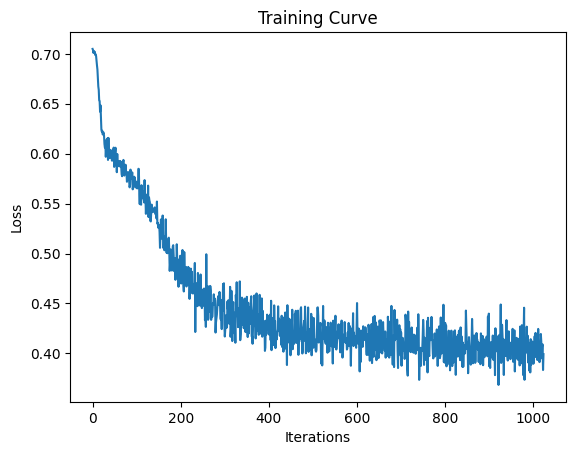

ValueError: x and y must have same first dimension, but have shapes (1024,) and (0,)

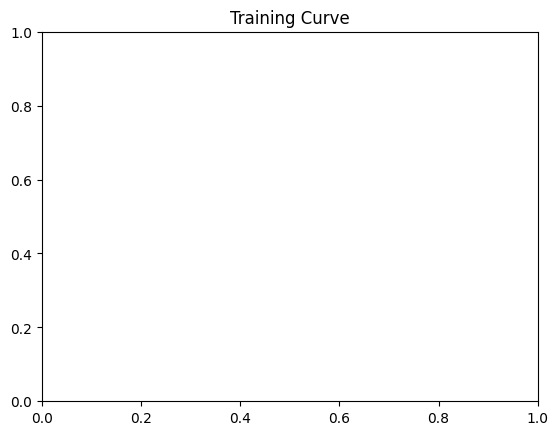

In [93]:
#train model
# INPUT_DIM = 10000
INPUT_DIM=10000
EMBEDDING_DIM = 256
HIDDEN_DIM = 128
OUTPUT_DIM = 8
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.2
# LEARNING_RATE = 0.00075
LEARNING_RATE = 0.00075
EPOCHS = 128

# #only use 10 datapoints from trainloader for testing
# train_loader = torch.utils.data.DataLoader(train[:10], batch_size=128, shuffle=True, collate_fn=pad_collate)
# valid_loader = torch.utils.data.DataLoader(valid[:10], batch_size=128, shuffle=True, collate_fn=pad_collate)

#only take the first 10 datapoints from trainloader for testing
# train = train[:10]
# train_loader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=True, collate_fn=pad_collate)

#activate GPU
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT)
train_net(model, BATCH_SIZE, LEARNING_RATE, EPOCHS)